In [3]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
import torch
import torch.nn as nn
import dynamic_nn_pt as dynn

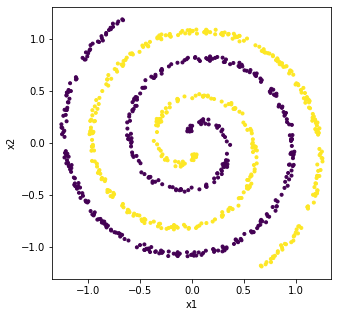

In [8]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

x, y = twospirals(400)
x, y = x/10, y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [14]:
dynet = dynn.Dynamic_Network(2, 1, final_activation=nn.Sigmoid(),
                             num_stat=5, num_std=250, decay_rate_std=0.03)
criterion = nn.BCELoss()

In [15]:
### hyperparameters
num_add_neuron = 6
num_decay_steps = 1000
threshold_max = 0.1
threshold_min = 0.001
learning_rate = 0.01

train_step_min = 1000
train_step_max = 5000

In [16]:
dynet.tree.add_to_remove_ratio = 2.

## Auto_Training

In [17]:
class AutoTrainer:
    
    def __init__(self):
        self.training_func = None
        self.adding_func = None
        self.pruning_func = None
        self.maintainance_func = None
        
    def loop(self, count = 15):
        cb = count
        while count>0:
            count-= 1
            self.adding_func()
            self.training_func()
            self.pruning_func()
            self.maintainance_func()
            
            print(f"=====================")
            print(f"===LOOPS FINISHED :{cb-count} ===")
        self.training_func()

### when to stop training functionality

In [18]:
def update_coeff(num_iter, coeff0, coeff1, coeff2, coeff_opt, loss_list):
    if len(loss_list)<10: return np.array([0]), np.array([0]), float(coeff0.data[0])
    
    _t = torch.tensor(loss_list)
    _t = (_t - _t[-1])/(_t[0]-_t.min()) ## normalize to make first point at 1 and last at 0 
    _t = torch.clamp(_t, -1.1, 1.1)
    _x = torch.linspace(0, 1, steps=len(_t))
    
    for _ in range(num_iter):
        coeff_opt.zero_grad()
        _y = torch.exp(coeff0*_x)*(1-_x)*coeff1 + coeff2

        _loss = ((_y - _t)**2).mean()
        _loss.backward()
        coeff_opt.step()

        coeff0.data = torch.clamp(coeff0.data, -20., 20.)
        coeff1.data = torch.clamp(coeff1.data, 0.7, 2.)
        coeff2.data = torch.clamp(coeff2.data, -0.2,0.1)
        
    if torch.isnan(coeff0.data[0]):
        coeff0.data[0] = 0.
        coeff1.data[0] = 0.
        coeff2.data[0] = 1. ## this gives signal
        
    _y = torch.exp(coeff0*_x)*(1-_x)*coeff1 + coeff2

    return _x.numpy(), _t.numpy(), _y.data.numpy()

In [19]:
# a = torch.FloatTensor([1, 5, np.nan])
# if torch.isnan(a[0]):
#     print('___')

## Train Network dynamically

In [20]:
## global variables
optimizer = None
coeff_opt = None

In [21]:
def add_neurons_func():
    global optimizer
    dynet.add_neurons(num_add_neuron)
    dynet.print_network()    
    optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
    return

In [22]:
def training_network_func():
    global optimizer
    
    coeff0 = torch.zeros(1, requires_grad=True)
    coeff1 = torch.zeros(1, requires_grad=True)
    coeff2 = torch.zeros(1, requires_grad=True)
    coeff_opt = torch.optim.Adam([coeff0, coeff1, coeff2], lr=0.8)
    loss_list = []
    
    %matplotlib tk
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    for epoch in range(train_step_max):

        dynet.decay_neuron_step()
        dynet.tree.std_loss = 0.    

        yout = dynet(xx)
        loss = criterion(yout, yy) + dynet.tree.decay_rate_std*dynet.tree.std_loss

        if epoch>100:
            loss_list.append(float(loss))

        optimizer.zero_grad()
        loss.backward(retain_graph=False)
        optimizer.step()

        if epoch%100 == 0:
            _x, _t, _y = update_coeff(50, coeff0, coeff1, coeff2, coeff_opt, loss_list)
            _c = float(coeff0.data[0])
#             if coeff2.data[0] > 0.5: ## this is a signal to reset optimizer
            coeff_opt = torch.optim.Adam([coeff0, coeff1, coeff2], lr=0.8)
            print(f'Epoch: {epoch}, Loss:{float(loss)}, coeff:{_c}')
            ax.clear()

            out = (yout.data.numpy()>0.5).astype(int)
            ax.scatter(x1, x2, c=out, marker='.')

            ax2.clear()
            if len(_x)>0:
                ax2.plot(_x, _y, c='m')
                ax2.plot(_x, _t, c='c')

            fig.canvas.draw()
            plt.pause(0.01)
            print("\n")

            if _c < -5 and epoch>train_step_min: break

    plt.close()
    return

In [23]:
def pruning_func():
    global optimizer
    optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
    
    
    dynet.start_computing_significance()

    for epoch in range(1):
        yout = dynet(xx)
        yout.backward(gradient=torch.ones_like(yout))
        optimizer.zero_grad()

    dynet.finish_computing_significance()
    dynet.identify_removable_neurons(num=None,
                                 threshold_min = threshold_min,
                                 threshold_max = threshold_max)
    num_remove = dynet.decay_neuron_start(decay_steps=num_decay_steps)
    if num_remove > 0:
        print(f"pruning {num_remove} neurons.")
        
        %matplotlib tk
        fig = plt.figure()
        ax = fig.add_subplot(111)

        for epoch in range(num_decay_steps):
            dynet.tree.std_loss = 0.

            yout = dynet(xx)
            loss = criterion(yout, yy) + dynet.tree.decay_rate_std*dynet.tree.std_loss

            optimizer.zero_grad()
            loss.backward(retain_graph=False)
            optimizer.step()

            dynet.decay_neuron_step()
            if epoch%100 == 0:
                print(f'Epoch: {epoch}, Loss:{float(loss)}')
                ax.clear()

                out = (yout.data.numpy()>0.5).astype(int)
                ax.scatter(x1, x2, c=out, marker='.')

                fig.canvas.draw()
                plt.pause(0.01)
                print("\n")

        plt.close()
    return

In [24]:
def maintain_network():
    dynet.compute_del_neurons()
    dynet.maintain_network()
    dynet.print_network()
    return

# Set all functions and begin automated loop

In [25]:
trainer = AutoTrainer()

In [26]:
trainer.adding_func = add_neurons_func
trainer.training_func = training_network_func
trainer.pruning_func = pruning_func
trainer.maintainance_func = maintain_network

In [ ]:
trainer.loop(15)

2
├────┐
│    6
├────┘
│
1
Epoch: 0, Loss:0.7826583981513977, coeff:0.0


Epoch: 100, Loss:0.6711252331733704, coeff:0.0


Epoch: 200, Loss:0.6518107056617737, coeff:-0.48713696002960205


Epoch: 300, Loss:0.6450179219245911, coeff:-1.3912534713745117


Epoch: 400, Loss:0.628625750541687, coeff:-0.1547853648662567


Epoch: 500, Loss:0.6141946911811829, coeff:0.08239012956619263


Epoch: 600, Loss:0.605050802230835, coeff:-0.04199368134140968


Epoch: 700, Loss:0.5864100456237793, coeff:-0.051981233060359955


Epoch: 800, Loss:0.5463331341743469, coeff:0.535980224609375


Epoch: 900, Loss:0.538644552230835, coeff:0.4687747359275818


Epoch: 1000, Loss:0.5335634350776672, coeff:0.22765739262104034


Epoch: 1100, Loss:0.5301180481910706, coeff:-0.04711837321519852


Epoch: 1200, Loss:0.5275359153747559, coeff:-0.306715726852417


Epoch: 1300, Loss:0.525619387626648, coeff:-0.562845766544342


Epoch: 1400, Loss:0.5239260792732239, coeff:-0.8072777390480042


Epoch: 1500, Loss:0.52243894338

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "




Epoch: 100, Loss:0.5143123269081116


Epoch: 200, Loss:0.5167674422264099


Epoch: 300, Loss:0.5206437706947327


Epoch: 400, Loss:0.5251108407974243


Epoch: 500, Loss:0.5311499834060669


Epoch: 600, Loss:0.541840672492981


Epoch: 700, Loss:0.5588092803955078


Epoch: 800, Loss:0.5756301283836365


Epoch: 900, Loss:0.5879731774330139


2
└────┐
     3
┌────┘
│
1
===LOOPS FINISHED :1 ===
2
└────┐
     ├────┐
     │    2
     ├────┘
     5
     ├────┐
     │    2
     ├────┘
┌────┘
│
1
Epoch: 0, Loss:0.5924493074417114, coeff:0.0


Epoch: 100, Loss:0.5511478185653687, coeff:0.0


Epoch: 200, Loss:0.528361976146698, coeff:0.5287712812423706


Epoch: 300, Loss:0.47834715247154236, coeff:0.4014071822166443


Epoch: 400, Loss:0.42794305086135864, coeff:0.2111654430627823


Epoch: 500, Loss:0.40715429186820984, coeff:-0.12515337765216827


Epoch: 600, Loss:0.400284081697464, coeff:-0.7522985339164734


Epoch: 700, Loss:0.3944718539714813, coeff:-1.2753798961639404


Epoch: 800, Loss:0.38

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "




Epoch: 100, Loss:0.333901584148407


Epoch: 200, Loss:0.32705172896385193


Epoch: 300, Loss:0.32107460498809814


Epoch: 400, Loss:0.32654136419296265


Epoch: 500, Loss:0.3393593728542328


Epoch: 600, Loss:0.36104047298431396


Epoch: 700, Loss:0.4016042649745941


Epoch: 800, Loss:0.42308706045150757


Epoch: 900, Loss:0.4411807656288147


2
└────┐
     ├────┐
     │    1
     ├────┘
     4
     ├────┐
     │    1
     ├────┘
┌────┘
│
1
===LOOPS FINISHED :2 ===
2
└────┐
     ├────┐
     │    2
     ├────┘
     7
     ├────┐
     │    3
     ├────┘
┌────┘
│
1
Epoch: 0, Loss:0.4452938735485077, coeff:0.0


Epoch: 100, Loss:0.3986778259277344, coeff:0.0


Epoch: 200, Loss:0.31790369749069214, coeff:0.13992621004581451


Epoch: 300, Loss:0.2806612253189087, coeff:-0.8781432509422302


Epoch: 400, Loss:0.2158508002758026, coeff:-0.3161088228225708


Epoch: 500, Loss:0.16694340109825134, coeff:0.0010922253131866455


Epoch: 600, Loss:0.1349227875471115, coeff:-0.2590979337692261


Epoc

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "




Epoch: 100, Loss:0.05355077609419823


Epoch: 200, Loss:0.05321448668837547


Epoch: 300, Loss:0.05588560551404953


Epoch: 400, Loss:0.06269156187772751


Epoch: 500, Loss:0.07907524704933167


Epoch: 600, Loss:0.1026282012462616


Epoch: 700, Loss:0.12319372594356537


Epoch: 800, Loss:0.2047404646873474


Epoch: 900, Loss:0.30386045575141907


2
└────┐
     ├────┐
     │    2
     ├────┘
     6
     ├────┐
     │    1
     ├────┘
┌────┘
│
1
===LOOPS FINISHED :3 ===
2
└────┐
     ├────┐
     │    4
     ├────┘
     6
     ├────┐
     │    5
     ├────┘
┌────┘
│
1
Epoch: 0, Loss:0.2630157172679901, coeff:0.0


Epoch: 100, Loss:0.18456684052944183, coeff:0.0


Epoch: 200, Loss:0.14236858487129211, coeff:-0.5632255673408508


Epoch: 300, Loss:0.13233916461467743, coeff:-1.7191274166107178


Epoch: 400, Loss:0.1236208900809288, coeff:-1.9003491401672363


Epoch: 500, Loss:0.11903634667396545, coeff:-2.2659382820129395


Epoch: 600, Loss:0.11430603265762329, coeff:-2.552321672439575


E

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


pruning 3 neurons.
Epoch: 0, Loss:0.020108085125684738


Epoch: 100, Loss:0.02184445410966873


Epoch: 200, Loss:0.02242015115916729


Epoch: 300, Loss:0.02357414923608303


Epoch: 400, Loss:0.025208599865436554


Epoch: 500, Loss:0.025588758289813995


Epoch: 600, Loss:0.02778385579586029


Epoch: 700, Loss:0.03565841168165207


Epoch: 800, Loss:0.05115237832069397


Epoch: 900, Loss:0.06723121553659439


2
└────┐
     ├────┐
     │    3
     ├────┘
     4
     ├────┐
     │    5
     ├────┘
┌────┘
│
1
===LOOPS FINISHED :4 ===
2
└────┐
     ├────┐
     │    6
     ├────┘
     5
     ├────┐
     │    6
     │    ├────┐
     │    │    1
     │    ├────┘
     ├────┘
┌────┘
│
1
Epoch: 0, Loss:0.05397644266486168, coeff:0.0


Epoch: 100, Loss:0.020317817106842995, coeff:0.0


Epoch: 200, Loss:0.015001865103840828, coeff:-1.830306887626648


Epoch: 300, Loss:0.013416036032140255, coeff:-1.4425671100616455


Epoch: 400, Loss:0.012545986101031303, coeff:-1.7214099168777466


Epoch: 500, Loss:

In [1]:
dynet.print_network()

NameError: name 'dynet' is not defined

In [2]:
%matplotlib inline
fig = plt.figure()
out = (dynet(xx).data.numpy()>0.5).astype(int)
ax = fig.add_subplot(111)
ax.scatter(x1, x2, c=out, marker='.')

NameError: name 'plt' is not defined